In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [3]:
import mlflow

# Ustawia URI śledzenia (gdzie będą zapisywane dane eksperymentów)
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
#mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Ustawia nazwę eksperymentu (organizuje przebiegi w grupy)
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='mlflow-artifacts:/442729487423546400', creation_time=1744790952863, experiment_id='442729487423546400', last_update_time=1744790952863, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
        df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])        
        
    elif filename.endswith('.parquet'):  
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

    df = df[(df['duration'] >=1) & (df['duration']<=60)]

    categorical = ['PULocationID','DOLocationID']
    df[categorical]= df[categorical].astype(str)
    
    return df

In [5]:
df_train = read_dataframe("data/green_tripdata_2021-01.parquet")
df_val= read_dataframe("data/green_tripdata_2021-02.parquet")

In [8]:
len(df_train), len(df_val)

(73908, 61921)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + "_" + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + "_" + df_val['DOLocationID']

In [15]:
categorial = ['PU_DO'] #['PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorial + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorial + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)


In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

### LinearRegression

In [32]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_val)

root_mean_squared_error(y_val,y_pred)

7.758715210206903

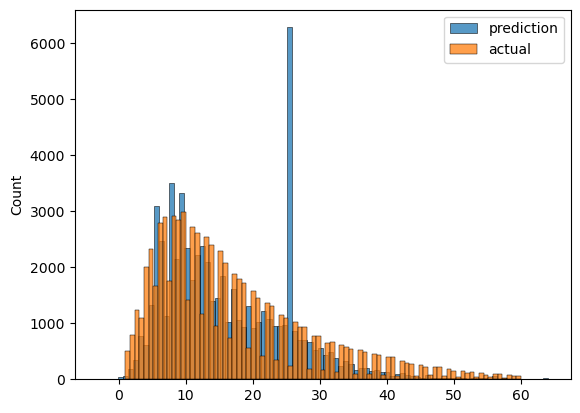

In [36]:
sns.histplot(y_pred, label = 'prediction')
sns.histplot(y_train, label = 'actual')

plt.legend()

### Lasso

In [40]:
with mlflow.start_run(run_name='model lasso'):
    
    mlflow.set_tag('developer', 'crostian')
    
    mlflow.log_param('train-data-path','data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path','data/green_tripdata_2021-02.parquet')

    alpha = 0.01
    mlflow.log_param('alpha',alpha)
    lasso = Lasso(alpha=alpha)
    
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_val)
    
    rmse = root_mean_squared_error(y_val,y_pred)
    mlflow.log_metric("Rmse", rmse)

    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

🏃 View run model lasso at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/8f6d59235f4c465a916512d9a4f2744d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400


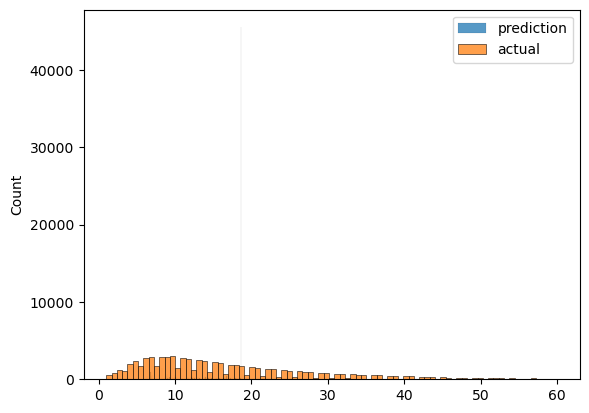

In [44]:
sns.histplot(y_pred, label = 'prediction')
sns.histplot(y_train, label = 'actual')

plt.legend()

### Ridge

In [46]:
mlflow.sklearn.autolog()
ridge = Ridge()
    
ridge.fit(X_train, y_train)
    
y_pred = ridge.predict(X_val)
    
root_mean_squared_error(y_val,y_pred)
mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

2025/05/06 18:20:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '51449d8a67d047e494a86f542e17bcf4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run orderly-zebra-776 at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/51449d8a67d047e494a86f542e17bcf4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400


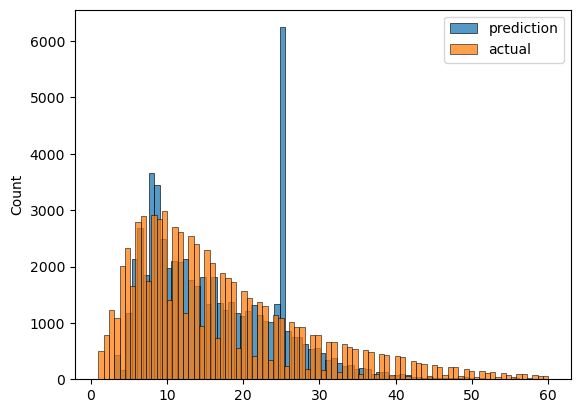

In [48]:
sns.histplot(y_pred, label = 'prediction')
sns.histplot(y_train, label = 'actual')

plt.legend()

### Save model

In [55]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,linear_reg), f_out)

### Xgboost

In [91]:
import xgboost as xgb
import numpy as np
    
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [93]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label = y_val)

In [95]:
print("y_val shape:", y_val.shape)
print("y_pred shape:", y_pred.shape)

y_val shape: (61921,)
y_pred shape: (61921,)


In [103]:
def objective(params):
    with mlflow.start_run(run_name='Xgboost'):
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid),
       # rmse = mean_squared_error(y_val,y_pred,squared= False)
       # rmse = root_mean_squared_error(y_val,y_pred)
        rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
        mlflow.log_metric("Rmse", rmse)

        with open('models/preprocessor.b', 'wb') as f_out:
            pickle.dump(dv,f_out)

        mlflow.log_artifact('models/preprocessor.b', artifact_path='preprocessor')

        mlflow.xgboost.log_model(booster, artifact_path='model_mlflow')

    return {'loss': rmse, 'status': STATUS_OK}

In [105]:
search_space = {
    'max_depth':scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate': hp.loguniform('learning_rate', -3,0),
    'reg_alpha': hp.loguniform('reg_alpha', -5,-1),
    'reg_lambda': hp.loguniform('reg_lambda',-6,-1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective': 'reg:linear',
    'seed':42,
}

In [ ]:
best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals= 50,
    trials= Trials())

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [11:58:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.23954                                                                                           
[1]	validation-rmse:8.91629                                                                                            
[2]	validation-rmse:8.05227                                                                                            
[3]	validation-rmse:7.50125                                                                                            
[4]	validation-rmse:7.15546                                                                                            
[5]	validation-rmse:6.93937                                                                                            
[6]	validation-rmse:6.80250                                                                                            
[7]	validation-rmse:6.71396                                                                                            
[8]	validation-rmse:6.65403             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [11:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 11:59:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/b11810f58d0249f4b5362ff26fd774b6   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

  2%|█                                                 | 1/50 [00:25<20:40, 25.31s/trial, best loss: 6.380743314752248]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [11:59:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.06156                                                                                           
[1]	validation-rmse:10.13387                                                                                           
[2]	validation-rmse:9.38976                                                                                            
[3]	validation-rmse:8.79609                                                                                            
[4]	validation-rmse:8.33197                                                                                            
[5]	validation-rmse:7.96322                                                                                            
[6]	validation-rmse:7.68124                                                                                            
[7]	validation-rmse:7.45588                                                                                            
[8]	validation-rmse:7.28465             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [11:59:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 11:59:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/4e3ea94c2a1e4aea8f19640e3e383448   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

  4%|██                                                | 2/50 [00:52<21:19, 26.66s/trial, best loss: 6.380743314752248]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [11:59:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78738                                                                                           
[1]	validation-rmse:11.39132                                                                                           
[2]	validation-rmse:11.02321                                                                                           
[3]	validation-rmse:10.68150                                                                                           
[4]	validation-rmse:10.36505                                                                                           
[5]	validation-rmse:10.07174                                                                                           
[6]	validation-rmse:9.80033                                                                                            
[7]	validation-rmse:9.54964                                                                                            
[8]	validation-rmse:9.31815             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:00:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/cb990911ca0a4250b199a828d364dee7   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

  6%|███                                               | 3/50 [02:13<40:03, 51.14s/trial, best loss: 6.380743314752248]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:00:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53771                                                                                           
[1]	validation-rmse:10.93823                                                                                           
[2]	validation-rmse:10.40503                                                                                           
[3]	validation-rmse:9.93348                                                                                            
[4]	validation-rmse:9.50965                                                                                            
[5]	validation-rmse:9.14367                                                                                            
[6]	validation-rmse:8.81667                                                                                            
[7]	validation-rmse:8.52711                                                                                            
[8]	validation-rmse:8.27662             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:02:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/41ae865217e84e1d90ae06fe1edec8e4   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

  8%|████                                              | 4/50 [03:32<47:47, 62.33s/trial, best loss: 6.380743314752248]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.13435                                                                                            
[1]	validation-rmse:6.74374                                                                                            
[2]	validation-rmse:6.69640                                                                                            
[3]	validation-rmse:6.68489                                                                                            
[4]	validation-rmse:6.67768                                                                                            
[5]	validation-rmse:6.67125                                                                                            
[6]	validation-rmse:6.66410                                                                                            
[7]	validation-rmse:6.66106                                                                                            
[8]	validation-rmse:6.65788             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:02:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/a4e34137d6644f8ca691d6c675d3812e   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 10%|█████                                             | 5/50 [03:41<32:15, 43.02s/trial, best loss: 6.380743314752248]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.21922                                                                                            
[1]	validation-rmse:7.81550                                                                                            
[2]	validation-rmse:7.19080                                                                                            
[3]	validation-rmse:6.91551                                                                                            
[4]	validation-rmse:6.78824                                                                                            
[5]	validation-rmse:6.72985                                                                                            
[6]	validation-rmse:6.69389                                                                                            
[7]	validation-rmse:6.67634                                                                                            
[8]	validation-rmse:6.66644             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:02:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/3d646f2f0a244048a40dd43907796c93   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 12%|██████                                            | 6/50 [03:57<24:44, 33.73s/trial, best loss: 6.325949294627145]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.86202                                                                                            
[1]	validation-rmse:8.46161                                                                                            
[2]	validation-rmse:7.65935                                                                                            
[3]	validation-rmse:7.21480                                                                                            
[4]	validation-rmse:6.96867                                                                                            
[5]	validation-rmse:6.82584                                                                                            
[6]	validation-rmse:6.74445                                                                                            
[7]	validation-rmse:6.69645                                                                                            
[8]	validation-rmse:6.66450             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:02:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/595c9c875ba441d5af09a0e1e5f0afeb   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 14%|███████                                           | 7/50 [04:19<21:29, 29.98s/trial, best loss: 6.325949294627145]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.84862                                                                                           
[1]	validation-rmse:9.78985                                                                                            
[2]	validation-rmse:8.97599                                                                                            
[3]	validation-rmse:8.36225                                                                                            
[4]	validation-rmse:7.90076                                                                                            
[5]	validation-rmse:7.55716                                                                                            
[6]	validation-rmse:7.29739                                                                                            
[7]	validation-rmse:7.10936                                                                                            
[8]	validation-rmse:6.96654             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:03:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/dd4d13649b614c69b03809d8a860a9fa   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 16%|████████                                          | 8/50 [04:49<21:06, 30.15s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.73702                                                                                            
[1]	validation-rmse:8.31782                                                                                            
[2]	validation-rmse:7.54212                                                                                            
[3]	validation-rmse:7.12849                                                                                            
[4]	validation-rmse:6.90450                                                                                            
[5]	validation-rmse:6.77782                                                                                            
[6]	validation-rmse:6.70834                                                                                            
[7]	validation-rmse:6.66582                                                                                            
[8]	validation-rmse:6.63949             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:03:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/d8a0f0e108c4448cb11911767c6ebf5d   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 18%|█████████                                         | 9/50 [05:03<17:07, 25.07s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72907                                                                                           
[1]	validation-rmse:11.28229                                                                                           
[2]	validation-rmse:10.87048                                                                                           
[3]	validation-rmse:10.49135                                                                                           
[4]	validation-rmse:10.14280                                                                                           
[5]	validation-rmse:9.82283                                                                                            
[6]	validation-rmse:9.52945                                                                                            
[7]	validation-rmse:9.26160                                                                                            
[8]	validation-rmse:9.01579             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:05:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/600da91478024bf18010a4a91ab3103d   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 20%|█████████▊                                       | 10/50 [06:33<30:04, 45.10s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.40450                                                                                           
[1]	validation-rmse:9.13540                                                                                            
[2]	validation-rmse:8.25970                                                                                            
[3]	validation-rmse:7.67391                                                                                            
[4]	validation-rmse:7.28373                                                                                            
[5]	validation-rmse:7.02631                                                                                            
[6]	validation-rmse:6.85539                                                                                            
[7]	validation-rmse:6.73972                                                                                            
[8]	validation-rmse:6.65956             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:05:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/3c4385c8209346678b5a7747aefb1431   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 22%|██████████▊                                      | 11/50 [06:58<25:16, 38.88s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.00290                                                                                           
[1]	validation-rmse:10.03613                                                                                           
[2]	validation-rmse:9.27516                                                                                            
[3]	validation-rmse:8.66670                                                                                            
[4]	validation-rmse:8.20195                                                                                            
[5]	validation-rmse:7.83067                                                                                            
[6]	validation-rmse:7.54100                                                                                            
[7]	validation-rmse:7.32204                                                                                            
[8]	validation-rmse:7.15404             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:06:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/2bab2b1460a044439bf979385487e8b5   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 24%|███████████▊                                     | 12/50 [07:52<27:33, 43.51s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.23507                                                                                            
[1]	validation-rmse:6.70791                                                                                            
[2]	validation-rmse:6.60079                                                                                            
[3]	validation-rmse:6.57274                                                                                            
[4]	validation-rmse:6.55983                                                                                            
[5]	validation-rmse:6.55264                                                                                            
[6]	validation-rmse:6.54028                                                                                            
[7]	validation-rmse:6.53428                                                                                            
[8]	validation-rmse:6.52881             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:06:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/2ff5fa87efc84b27bf217151042057b9   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 26%|████████████▋                                    | 13/50 [08:08<21:45, 35.28s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.51258                                                                                            
[1]	validation-rmse:8.07236                                                                                            
[2]	validation-rmse:7.35120                                                                                            
[3]	validation-rmse:6.98387                                                                                            
[4]	validation-rmse:6.79638                                                                                            
[5]	validation-rmse:6.69587                                                                                            
[6]	validation-rmse:6.64351                                                                                            
[7]	validation-rmse:6.60380                                                                                            
[8]	validation-rmse:6.58025             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:07:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/e8da5979dc73422c8c927380dfc97ef3   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 28%|█████████████▋                                   | 14/50 [08:34<19:21, 32.26s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.16605                                                                                           
[1]	validation-rmse:8.83944                                                                                            
[2]	validation-rmse:8.00846                                                                                            
[3]	validation-rmse:7.50021                                                                                            
[4]	validation-rmse:7.19147                                                                                            
[5]	validation-rmse:7.00462                                                                                            
[6]	validation-rmse:6.89266                                                                                            
[7]	validation-rmse:6.81753                                                                                            
[8]	validation-rmse:6.76718             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:07:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/86eca6739ed44322ad9d322a0cd9178b   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 30%|██████████████▋                                  | 15/50 [09:02<18:04, 31.00s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.12139                                                                                           
[1]	validation-rmse:10.22077                                                                                           
[2]	validation-rmse:9.48230                                                                                            
[3]	validation-rmse:8.88379                                                                                            
[4]	validation-rmse:8.40040                                                                                            
[5]	validation-rmse:8.01361                                                                                            
[6]	validation-rmse:7.70537                                                                                            
[7]	validation-rmse:7.45862                                                                                            
[8]	validation-rmse:7.26616             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:08:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/59fe4f78a46c4d81910279b0527077e8   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 32%|███████████████▋                                 | 16/50 [09:49<20:19, 35.87s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.83348                                                                                            
[1]	validation-rmse:7.46031                                                                                            
[2]	validation-rmse:6.93948                                                                                            
[3]	validation-rmse:6.73333                                                                                            
[4]	validation-rmse:6.63895                                                                                            
[5]	validation-rmse:6.59187                                                                                            
[6]	validation-rmse:6.56628                                                                                            
[7]	validation-rmse:6.54978                                                                                            
[8]	validation-rmse:6.53563             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:08:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/67af446a95fa4be08f3bc2876b379078   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 34%|████████████████▋                                | 17/50 [10:13<17:45, 32.29s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.11290                                                                                            
[1]	validation-rmse:7.67548                                                                                            
[2]	validation-rmse:7.05596                                                                                            
[3]	validation-rmse:6.78367                                                                                            
[4]	validation-rmse:6.66176                                                                                            
[5]	validation-rmse:6.59299                                                                                            
[6]	validation-rmse:6.55718                                                                                            
[7]	validation-rmse:6.53746                                                                                            
[8]	validation-rmse:6.52066             

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

2025/04/16 12:09:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run Xgboost at: http://127.0.0.1:5000/#/experiments/442729487423546400/runs/bc8fb4bbbc7948d79aa182411e00e555   

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/442729487423546400                                          

 36%|█████████████████▋                               | 18/50 [10:39<16:15, 30.48s/trial, best loss: 6.299880340449103]

C:\Users\MOlsz\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.80179                                                                                            
[1]	validation-rmse:8.36107                                                                                            
[2]	validation-rmse:7.54262                                                                                            
[3]	validation-rmse:7.07863                                                                                            
[4]	validation-rmse:6.82759                                                                                            
[5]	validation-rmse:6.68276                                                                                            
[6]	validation-rmse:6.59695                                                                                            
[7]	validation-rmse:6.54483                                                                                            
[8]	validation-rmse:6.50901             